Document for Model training



Importing packages

In [1]:
import matplotlib.pyplot as plt
from synDataFunctionality.TreeLib import Tree, genTree
import numpy as np
from synDataFunctionality.genInputFromLabel import labelToInput


Setting Constants

In [2]:
startX = 5
startY = 360
startAngle = 0
starWidth = 20
stopWidth = 2
startLength = 20
bifurcProb = 0.3 #should be changed to prop dist dependent on number of 'straigt' lines

Make some trees 

In [3]:
from synDataFunctionality.saveSynData import genSynDat
import torch.utils.data as td
from DataLoaders import SynData

Make and save some synthetic data

In [4]:
lst = [startX, startY, starWidth, startLength, startAngle, stopWidth, 0.3]
num = 3

# make num samples
genSynDat("SynDat/SynInput", "SynDat/SynLabel", lst, (736, 736), num)


2.4191126121616993
2.4109342591442964
2.3627155739614105
2.315461262482182
2.2691520372325384
2.2691122803304036
2.2237300347237956
2.1792554340293195
2.135670325348733
2.0929569188417583
2.051097780464923
2.0495207902339625
2.008530374429283
2.1561327960756427
2.1130101401541297
2.070749937351047
2.029334938604026
2.081013355899508
2.0393930887815177
2.4682587279155217
2.4188935533572113
2.3705156822900673
2.3231053686442658
2.2766432612713805
2.231110396045953
2.1126782730174196
2.105402115219377
2.0632940729149896
2.0220281914566898
2.4758521821277863
2.3607592085637403
2.354093920011089
2.307012041610867
2.2608718007786495
2.2156543647630764
2.171341277467815
2.1279144519184587
2.480687987355025
2.442561206046096
2.4423828312281843
2.3935351746036204
2.0777813598257127
2.036225732629198
2.1047774359448983
2.104216220185613
2.0621318957819006
2.0582355706806665
2.017070859267053
2.0142210959253637
2.2129472723603887
2.1280961056109966
2.0855341834987766
2.043823499828801
2.011650446

Test that we can make a dataSet and it outputs data as expected

In [5]:
from torchvision.transforms import Resize
import torchvision

SynDataSet = SynData("SynDat/synInput", "SynDat/synLabel")

#Test we can retrieve data from Dataset
test, lab = SynDataSet[0]
print(test.shape)
print(lab.shape)


torch.Size([1, 736, 736])
torch.Size([1, 736, 736])


Visualize synthetic generated data

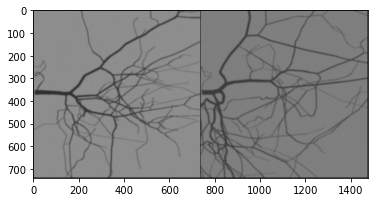

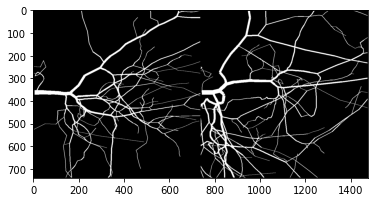

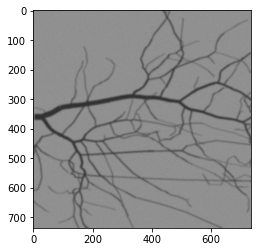

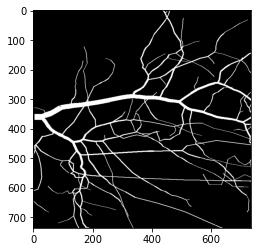

In [6]:
import torchvision

#test that dataloader works, and show images
test_loader = td.DataLoader(SynDataSet, batch_size=2)

testIter = iter(test_loader)
for i in range(len(testIter)):
    imgs, labs = testIter.next()
    grid = torchvision.utils.make_grid(imgs) #.numpy()[0] hack to show tensor in plt
    plt.imshow(grid.numpy()[0], cmap="gray", vmin=0, vmax=255)
    plt.show()
    lab_grid = torchvision.utils.make_grid(labs)
    plt.imshow(lab_grid.numpy()[0], cmap="gray", vmin=0, vmax=1)
    plt.show()

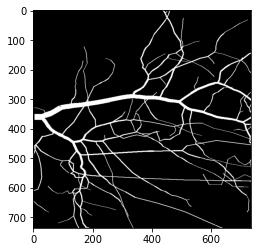

In [7]:
lab, dat = SynDataSet[2]
plt.imshow(dat.numpy()[0], cmap="gray")
plt.imsave("test.PNG", dat.numpy()[0])
plt.show()

Check that transformations can be applied to dataSet

In [13]:
#Test transformations work correctly on dataloader:
from torchvision.transforms import RandomVerticalFlip, RandomHorizontalFlip, Resize, CenterCrop, Normalize
from torchvision.transforms.functional import rotate
import torchvision

t_both = [RandomHorizontalFlip(p=0.5),  RandomVerticalFlip(p=0.5), Resize(size=(640, 640))]
#Maybe normalize imgs automatically in dataSet

In [14]:
TransDataSet = SynData("SynDat/synInput", "SynDat/synLabel", transforms_both=t_both, repeat_channels=True)

In [6]:
import torchvision
import numpy as np

#test that dataloader works, and show images
trans_loader = td.DataLoader(TransDataSet, batch_size=2)

transIter = iter(trans_loader)
for i in range(len(transIter)):
    imgs, labs = next(transIter)
    grid = torchvision.utils.make_grid(imgs).numpy()[0]
    #print(np.amax(np.array(imgs)))
    #print(np.amin(np.array(imgs)))
    plt.imshow(grid+1, cmap="gray", vmin=0, vmax=255)
    plt.show()
    lab_grid = torchvision.utils.make_grid(labs).numpy()[0]
    plt.imshow(lab_grid, cmap="gray", vmin=0, vmax=1)
    plt.show()

Experiment with Basic Unet (to test whether it works)

Import packages and files for Unet and training

In [27]:
from Unet.UNetBasic import UnetBasic
import torch
import torch.optim as optim
import torch.nn as nn
import torch.cuda


In [28]:
#make Unet

net1 = UnetBasic()


#Try to use cuda machine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#check which device we are on

print(device)


cpu


Make training and testing images. Apply random transformations to them:

In [27]:
#note, we comment our genSynDat, as otherwise we kill previous generated data.


#Make 300 samples for training data:
#genSynDat("SynDat/SynInputTrain", "SynDat/SynLabelTrain", lst, (736, 736), 300)

#Make 50 samples as test data:
#genSynDat("SynDat/SynInputTest", "SynDat/SynLabelTest", lst, (736, 736), 50)

In [30]:
#Make datasets

trainingData = SynData("SynDat/synInput", "SynDat/synLabel", t_both)
testData = SynData("SynDat/synInput", "SynDat/synLabel", t_both)

trainLoader = td.DataLoader(trainingData, shuffle=True)
testLoader = td.DataLoader(testData, shuffle=True)

Training our basic Unet

In [29]:
from trainingFunctionality import trainLoop

net1.to(device) #For now is cpu, but will hopefully be CUDA later
net1 = net1.float() #hack that should remove float error

#Adam for now
optimizer = optim.Adam(net1.parameters(), lr=0.001)
criterion = nn.BCELoss()
criterion.to(device)
epochs = 5

#Training, pray for me. Idea; only print av. epoch error. Decide later
trainLoss, testLoss, net = trainLoop(net1, optimizer, criterion, device, epochs, trainLoader, testLoader, print_interv=5)

[1,     5] loss: 0.132
[1,    10] loss: 0.114
[1,    15] loss: 0.104
[1,    20] loss: 0.097
[1,    25] loss: 0.090
[1,    30] loss: 0.085
[1,    35] loss: 0.082
[1,    40] loss: 0.078
[1,    45] loss: 0.074
[1,    50] loss: 0.070
[1,    55] loss: 0.068
[1,    60] loss: 0.065
[1,    65] loss: 0.062
[1,    70] loss: 0.060
[1,    75] loss: 0.057
[1,    80] loss: 0.054
[1,    85] loss: 0.052
[1,    90] loss: 0.049
[1,    95] loss: 0.047
[1,   100] loss: 0.045
[1,   105] loss: 0.044
[1,   110] loss: 0.042
[1,   115] loss: 0.040
[1,   120] loss: 0.038
[1,   125] loss: 0.036
[1,   130] loss: 0.035
[1,   135] loss: 0.033
[1,   140] loss: 0.032
[1,   145] loss: 0.031
[1,   150] loss: 0.029
[1,   155] loss: 0.028
[1,   160] loss: 0.027
[1,   165] loss: 0.027
[1,   170] loss: 0.025
[1,   175] loss: 0.024
[1,   180] loss: 0.023
[1,   185] loss: 0.021
[1,   190] loss: 0.021
[1,   195] loss: 0.020
[1,   200] loss: 0.019
[1,   205] loss: 0.018
[1,   210] loss: 0.017
[1,   215] loss: 0.016
[1,   220] 

Save model, such that we do not need to retrain

In [30]:
#save model
modelPath = "savedModels/"
UnetName = "FirstUnet"
saveModel = False

#save model
torch.save(net.state_dict(), (modelPath + UnetName))

#Create unet
unetBasic = UnetBasic().to(device)
#load trained model's parameters into unet
unetBasic.load_state_dict(torch.load((modelPath + UnetName)))

<All keys matched successfully>

[0.6308110356330872, 0.564461350440979, 0.5130776166915894, 0.47463470697402954, 0.44594502449035645, 0.4219803214073181, 0.4022577106952667, 0.38375726342201233, 0.3752394914627075, 0.3507709503173828, 0.33388084173202515, 0.31879106163978577, 0.3087765574455261, 0.29757148027420044, 0.2800254225730896, 0.2681008577346802, 0.2575618326663971, 0.2450276017189026, 0.2368926852941513, 0.22681008279323578, 0.21950943768024445, 0.20416909456253052, 0.20114536583423615, 0.19651766121387482, 0.18077580630779266, 0.16942782700061798, 0.16747230291366577, 0.16057109832763672, 0.150922954082489, 0.14710097014904022, 0.1366136074066162, 0.13080379366874695, 0.12614139914512634, 0.12143423408269882, 0.11587688326835632, 0.11043691635131836, 0.10659667104482651, 0.10035518556833267, 0.09683447331190109, 0.09605952352285385, 0.09062696993350983, 0.08570229262113571, 0.08217338472604752, 0.07856778800487518, 0.07525976747274399, 0.07350195944309235, 0.07092076539993286, 0.06930974125862122, 0.070801

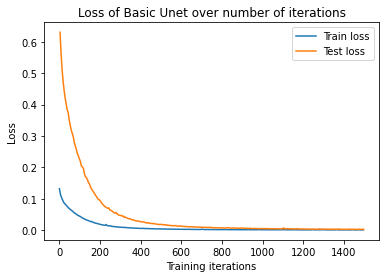

[0.017774084582924843, 0.01673290692269802, 0.017445681616663933, 0.016172243282198906, 0.017300110310316086, 0.015464811585843563, 0.01541933510452509, 0.015226319432258606, 0.014614830724895, 0.014195437543094158, 0.013895172625780106, 0.013800343498587608, 0.013678885996341705, 0.01361857634037733, 0.014608561992645264, 0.012567454017698765, 0.012449512258172035, 0.01214899867773056, 0.013516451232135296, 0.012424702756106853, 0.011913415044546127, 0.01159326359629631, 0.011278044432401657, 0.0117234718054533, 0.010709693655371666, 0.011215702630579472, 0.010553749278187752, 0.010476970113813877, 0.0102574797347188, 0.010213831439614296, 0.010347689501941204, 0.00972437858581543, 0.010350474156439304, 0.009718888439238071, 0.009709273464977741, 0.009518095292150974, 0.009286319836974144, 0.009258062578737736, 0.009135441854596138, 0.00891895405948162, 0.008768334053456783, 0.008776061236858368, 0.008491309359669685, 0.008559116162359715, 0.008361919783055782, 0.00857544969767332, 0.

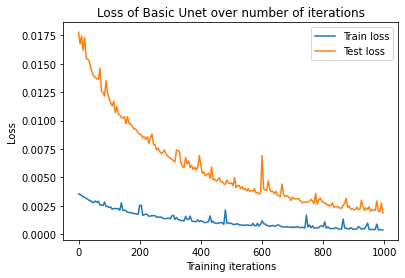

In [34]:
from trainingFunctionality import visualizeLoss #need to fix
visualizeLoss("Basic Unet", 5, trainLoss, testLoss)
visualizeLoss("Basic Unet", 5, trainLoss[100:], testLoss[100:]) #something funky going on. Why does it stop at 1000 and not 1300??

In [32]:
from sklearn.metrics import f1_score
#Visualize a prediction of transIter

#Make test dataset
testData = SynData("SynDat/SynInput/", "SynDat/SynLabel/")
testLoader = td.DataLoader(testData, shuffle=True)

# Check if works with batches
def testNet(net, testLoader, illustrate=False):
    testIter = iter(testLoader)
    acum_score = 0
    for i in range(len(testIter)):
        test_input, test_lab_orig = next(testIter)
        #predict
        test_input, test_lab = test_input.to(device), test_lab_orig.to(device)
        #detach from device
        test_out = (net(test_input.float())).cpu().detach() #put output back on cpu
        #formatér
        orig_lab = test_lab_orig.numpy()[0]
        pred_lab = np.array(test_out.numpy()[0] > 0.5).astype(int)
        #compute f1 score
        score = f1_score(orig_lab[0], pred_lab[0], average="micro")
        acum_score += score

        if illustrate:
            print("actual label:")
            plt.imshow(torchvision.utils.make_grid(test_lab_orig).numpy()[0], cmap="gray", vmin=0, vmax=1)
            plt.show()
            print("predicted lab:")
            plt.imshow(torchvision.utils.make_grid(test_out).numpy()[0] > 0.5, cmap="gray", vmin=0, vmax=1)
            plt.show()
        #print f1 score
        print("f1 score: {0:.5f}".format(score))
        print()
    print("Mean f1 score: {0:.5f}".format(acum_score/len(testLoader)))

testNet(unetBasic, testLoader)

f1 score: 0.99931

f1 score: 0.99946

f1 score: 0.99937

f1 score: 0.99913

f1 score: 0.99939

f1 score: 0.99939

f1 score: 0.99953

f1 score: 0.99903

f1 score: 0.99946

Mean f1 score: 0.99934


Kill all files created in this session, such to diminish clutter

In [33]:
#kill generated files such that we diminish clutter
from synDataFunctionality.saveSynData import order_66

#order_66("SynDat/synInputTrain", "SynDat/synLabelTrain")
